“MentorHub” — это сервис, который помогает менторам и менти найти друг друга. Встречи проходят на площадке сервиса. Назначить встречу можно в личном кабинете после авторизации на сайте.

Продакт-менеджер  начал подготовку к новому этапу развития приложения и попросил вас собрать данные о работе сервиса.

Изучите данные и подготовьте ответы на вопросы:

1. Какое количество менторов и менти взаимодействуют каждый месяц на нашей платформе? Как меняется этот показатель из месяца в месяц?
2. Сколько у каждого ментора в среднем успешных сессий в неделю по месяцам? Как меняется частота встреч в неделю от месяца к месяцу?
3. Сколько времени в среднем проходит между менторскими встречами у одного менти? ментора?
4. Сколько сессий по каждому направлению менторства в месяц обычно отменяется? Как меняется доля отмененных сессий помесячно?
5. В какой день недели последнего полного месяца прошло больше всего встреч?

Импорт библиотек

In [51]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

Подключаюсь к Базе Данных

In [52]:
db_config = {'user': 'mentor',
             'pwd': 'm06uz3.tMQ017y8n',
             'host': '185.86.147.205',
             'port': 5432,
             'db': 'db_mentor'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
engine = create_engine(connection_string)

In [53]:
def select(sql):
  return pd.io.sql.read_sql(sql, con = engine)

Изучение структуры данных

In [54]:
# Проверка пользователей на уникальность
sql = '''
SELECT count(*) as all_id, count(distinct user_id) as uniq_id
FROM users
'''
select(sql)

,all_id,uniq_id
0,3132,3132


Расчет количества зарегистрированных менторов и менти на платформе

In [75]:
sql = '''
SELECT role,
      count(user_id) as user_count
FROM users
GROUP BY role
'''
select(sql)

,role,user_count
0,mentee,2509
1,mentor,623


**Вопрос №1.**
Какое количество менторов и менти взаимодействуют каждый месяц на нашей платформе? Как меняется этот показатель из месяца в месяц?

In [56]:
sql = '''
SELECT  date_trunc('month', session_date_time) :: date as session_month,
        count(DISTINCT mentee_id) :: int as mentee_cnt,
        count(DISTINCT mentor_id) :: int as mentor_cnt
FROM    sessions s
GROUP BY
        session_month
ORDER BY
        session_month
                '''

select(sql)

,session_month,mentee_cnt,mentor_cnt
0,2021-02-01,3,3
1,2021-03-01,3,3
2,2021-04-01,7,7
3,2021-05-01,19,18
4,2021-06-01,27,24
5,2021-07-01,35,37
6,2021-08-01,56,53
7,2021-09-01,70,63
8,2021-10-01,89,86
9,2021-11-01,114,102


Данные имеют четкую восходящую динамику, прирост идет от месяца к месяцу. Но в сентябре показатели начинают падать. Нужно проверить в чем может быть причина.

In [74]:
# Крайняя дата в сентябре это 15 число, значит данные представлены не в полном обьеме,
# поэтому идет спад активности в этом месяце
sql = '''
SELECT max(session_date_time) as max_date
FROM sessions
'''
select(sql)

,max_date
0,2022-09-15


Снижение показателей в сентября связано с тем, что данные за месяц не полные

**Вопрос №2.**
Сколько у каждого ментора в среднем успешных сессий в неделю по месяцам? Как меняется частота встреч в неделю от месяца к месяцу?

In [93]:
#  avg - среднее количество успешных сессий
sql = '''
WITH month_week_table as
(
    SELECT  mentor_id,
            date_trunc('month', session_date_time) :: date as session_month,
            EXTRACT(month from session_date_time) as month_n,
            EXTRACT(week from session_date_time) as week_n,
            count(session_id) as session_per_week
    FROM    sessions s
    WHERE   session_status = 'finished'
    GROUP BY
            mentor_id,
            session_month,
            month_n,
            week_n
)

SELECT  mentor_id,
        session_month :: date,
        month_n :: int,
        avg(session_per_week) :: int as avg_session_per_week
FROM    month_week_table
GROUP BY
        mentor_id,
        session_month,
        month_n
ORDER BY
        avg_session_per_week DESC
                '''
select(sql).head()

,mentor_id,session_month,month_n,avg_session_per_week
0,3802,2022-09-01,9,15
1,772,2022-09-01,9,10
2,4123,2022-09-01,9,8
3,3105,2022-09-01,9,8
4,3347,2022-09-01,9,7


<Axes: xlabel='month', ylabel='mentor_quantity'>

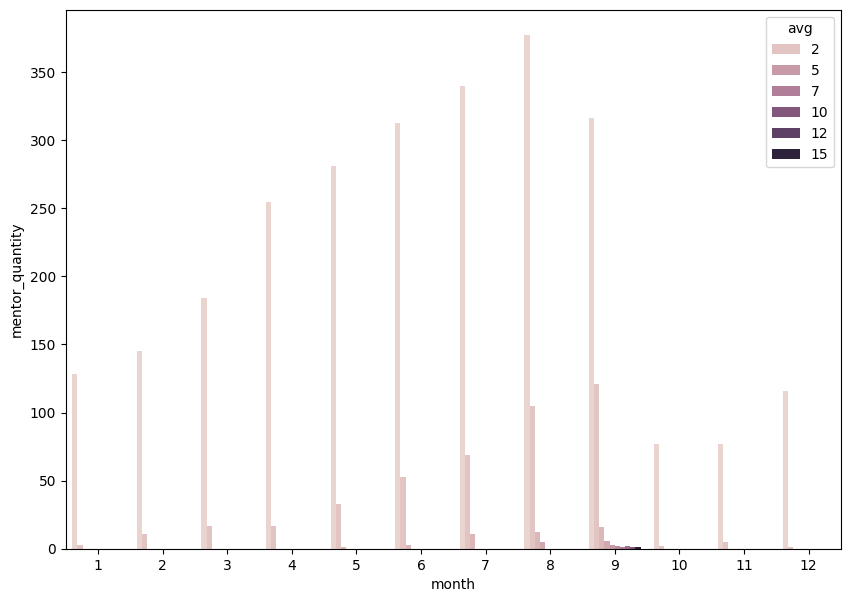

In [59]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data=(select(sql)
                  .groupby(['month', 'avg'])
                  .agg(mentor_quantity = ('mentor_id', 'nunique'))),
            x="month", y="mentor_quantity",
            hue="avg")

С мая менторы стали проводить стабильно в среднем 2 сессии в неделю, для дальнейших месяцев среднее количество сессий еще увеличилось. В сентябре есть менторы, которые провели более 5 сессий.

In [72]:
# ТОП 5 менторов по количеству сессий за последний полный месяц (август 2022 года)

sql = '''
WITH session_per_mentor AS
(
    SELECT  mentor_id,
            count(session_id) as session_quantity
    FROM    sessions s
    WHERE   session_date_time :: date BETWEEN '2022-08-01' AND '2022-08-31'
    GROUP BY
            mentor_id
),
session_quantity_numeration AS
(
    SELECT  mentor_id,
            session_quantity,
            DENSE_RANK () OVER (ORDER BY session_quantity DESC) as dr
    FROM    session_per_mentor
)

SELECT  mentor_id
FROM    session_quantity_numeration
WHERE   dr <= 5
                '''

select(sql).head(5)

,mentor_id
0,4256
1,2192
2,1903
3,1552
4,4798


**Вопрос №3.**
Сколько времени в среднем проходит между менторскими встречами у одного менти? ментора?

In [94]:
# Среднее время между встречами у менторов
sql = '''
WITH next_session_dt_preparation AS
(
    SELECT  mentor_id,
            session_date_time,
            LEAD (session_date_time) OVER (PARTITION BY mentor_id ORDER BY session_date_time) as next_session_dt,
            ROW_NUMBER () OVER (PARTITION BY mentor_id ORDER BY session_date_time) as rn
    FROM    sessions s
),
day_diff_table AS
(
    SELECT  *,
            date_part('day', next_session_dt - session_date_time) as day_diff
    FROM    next_session_dt_preparation
    WHERE   rn = 1
)

SELECT  mentor_id,
        day_diff
FROM    day_diff_table
                '''

select(sql)['day_diff'].describe()

,day_diff
count,623.000000
mean,46.797753
std,57.018282
min,0.000000
25%,7.000000
50%,25.000000
75%,62.000000
max,326.000000


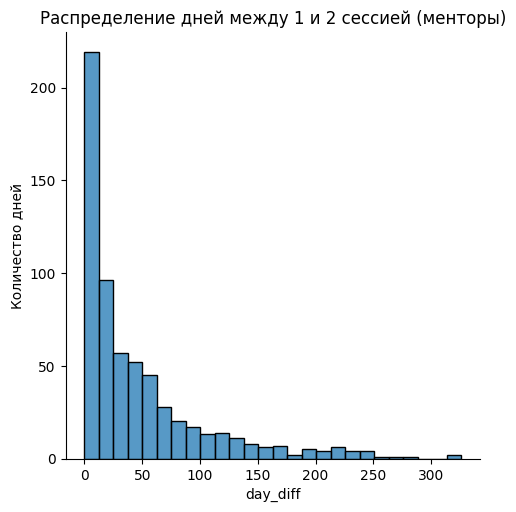

In [87]:
sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менторы)')
plt.ylabel('Количество дней')
plt.show()

In [95]:
# Среднее время между встречами у менти
sql = '''
WITH next_session_dt_preparation AS
(
    SELECT  mentee_id,
            session_date_time,
            LEAD (session_date_time) OVER (PARTITION BY mentee_id ORDER BY session_date_time) as next_session_dt,
            ROW_NUMBER () OVER (PARTITION BY mentee_id ORDER BY session_date_time) as rn
    FROM    sessions s
),
day_diff_table AS
(
    SELECT  *,
            date_part('day', next_session_dt - session_date_time) as day_diff
    FROM    next_session_dt_preparation
    WHERE   rn = 1
)

SELECT  mentee_id,
        day_diff
FROM    day_diff_table
                '''

select(sql)['day_diff'].describe()

,day_diff
count,1497.000000
mean,74.554442
std,82.103397
min,0.000000
25%,16.000000
50%,46.000000
75%,107.000000
max,509.000000


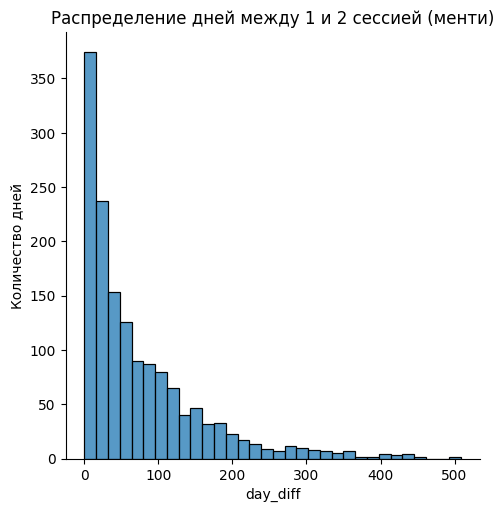

In [85]:
sns.displot(data=select(sql), x="day_diff")
plt.title('Распределение дней между 1 и 2 сессией (менти)')
plt.ylabel('Количество дней')
plt.show()

Распределения имеют длинные хвосты, но несмотря на это 50% пользователей, которые приняли участие во второй сессии сделали это в течение месяца (для менторов) и в течение полутора месяцев для менти.

**Вопрос №4**
Сколько сессий по каждому направлению менторства в месяц обычно отменяется? Как меняется доля отмененных сессий помесячно?

Рассчитаем долю отмен от всех назначенных сессий.

In [96]:
# Сентябрь 2022 года не учитываю т.к данные за месяц не полные
sql = '''
SELECT  date_trunc('month', session_date_time) :: date as session_month,
        count(session_id) as all_session,
        round(count(session_id) FILTER (WHERE session_status = 'canceled') :: numeric/ count(session_id), 2) as canceled_percent
FROM    sessions
WHERE   session_date_time :: date < '2022-09-01'
GROUP BY
        session_month
ORDER BY
        session_month
                '''

select(sql)

,session_month,all_session,canceled_percent
0,2021-02-01,3,0.00
1,2021-03-01,3,0.00
2,2021-04-01,7,0.29
3,2021-05-01,19,0.21
4,2021-06-01,27,0.15
5,2021-07-01,37,0.19
6,2021-08-01,59,0.10
7,2021-09-01,71,0.13
8,2021-10-01,101,0.11
9,2021-11-01,119,0.20


In [90]:
select(sql)['canceled_percent'].describe()

,canceled_percent
count,19.000000
mean,0.151053
std,0.067321
min,0.000000
25%,0.130000
50%,0.160000
75%,0.185000
max,0.290000


Медианное и среднее значение досточно близки. Это значит, что  метрика (доля отмен) не склонна к выбросам.

**Вопрос №5**
Определите, в какой день недели последнего полного месяца прошло больше всего встреч. В результате выведите названия сферы и необходимые данные.

In [92]:
sql = '''
WITH session_per_week_day AS
(
    SELECT  d."name"  domain_name,
            to_char(s.session_date_time, 'dy') week_day,
            count(session_id) session_quantity
    FROM    sessions s
            INNER JOIN "domain" d
                ON s.mentor_domain_id = d.id
    WHERE   session_date_time :: date BETWEEN '2022-08-01' AND '2022-08-31'
    GROUP BY
            domain_name,
            week_day
),
dense_rank_table AS
(
    SELECT  *,
            DENSE_RANK() OVER (PARTITION BY domain_name ORDER BY session_quantity DESC) dr
    FROM    session_per_week_day
)

SELECT  domain_name,
        week_day,
        session_quantity
FROM    dense_rank_table
WHERE   dr = 1
                '''

select(sql)

,domain_name,week_day,session_quantity
0,AB тестирование,tue,27
1,DS,wed,40
2,Python для аналитики данных,wed,40
3,SQL,mon,47
4,Визуализация данных,wed,29
5,Машинное обучение,tue,42
6,Продуктовая аналитика,sun,35


Самый загруженный день - среда